<a href="https://colab.research.google.com/github/PotoyanGroup/MD-cookbook/blob/main/MetadynOpenmm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
%%capture
!conda install -c conda-forge openmm openmmtools mdtraj nglview

In [ ]:
import openmm
from openmm import *
from openmm.app import *
from openmm.unit import *

import matplotlib.pyplot as plt
import mdtraj  as md
import numpy   as np
import pandas  as pd

import openmmtools
from   openmmtools  import testsystems


### Create alanine dipeptide all-atom simulation

In [ ]:
# Grab alaine dipeptide
dialanine = testsystems.AlanineDipeptideExplicit()
system, positions, topology = dialanine.system, dialanine.positions, dialanine.topology

from openmm.app import PDBFile
with open("dialanine.pdb", "w") as f:
    PDBFile.writeFile(dialanine.topology, dialanine.positions, f)


#import nglview as nv
#pdb = md.load_pdb("dialanine.pdb")
#view = nv.show_mdtraj(pdb)
#view.add_ball_and_stick('all')
#view.center_view(zoom=True)
#view

### Setup  simulation in OpenMM



In [11]:
# Simulation parameters for explicit solvent all-atom system
nonbondedMethod     = PME
nonbondedCutoff     = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints         = HBonds
rigidWater          = True
constraintTolerance = 1e-5
hydrogenMass        = 1.5*amu

dt                 = 2.0 * femtoseconds
temperature        = 300*kelvin
friction           = 1.0/picosecond
pressure           = 1.0*atmospheres
barostatInterval   = 25
equilibrationSteps = 10000
nsteps              = 2500000  # ~5 ns if dt = 2 fs  

#Reporters
dcdReporter        = DCDReporter('trajectory.dcd', 1000)
dataReporter       = StateDataReporter('log.txt', 1000, 
                                 totalSteps=steps,
                                 step=True, 
                                 speed=True, progress=True, 
                                 potentialEnergy=True, 
                                 temperature=True, 
                                 separator='\t')

### Run NPT simulation

In [ ]:
# Prepare the Simulation
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))

integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

# Minimize 
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)

simulation.step(nsteps)

### Metadynamics simulation of alanine dipeptide


In [ ]:
# CV setup
num_grid_pts = 25
resolution = 2 * np.pi / num_grid_pts  # bin width in radians
bias_factor = 3

# Torsion atom indices
psi_indices = [6, 8, 14, 16]
phi_indices = [4, 6, 8, 14]

# Define collective variables (CVs) as torsion angles
cv1 = CustomTorsionForce('theta')
cv1.addTorsion(*psi_indices)
system.addForce(cv1)
psi = BiasVariable(cv1, -np.pi, np.pi, resolution, True)

cv2 = CustomTorsionForce('theta')
cv2.addTorsion(*phi_indices)
system.addForce(cv2)
phi = BiasVariable(cv2, -np.pi, np.pi, resolution, True)

# Add barostat
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))

# Integrator and Simulation object
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator)
simulation.context.setPositions(positions)

# Energy minimization and equilibration
simulation.minimizeEnergy()
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Set up Metadynamics
meta = Metadynamics(system,
                    [phi, psi],
                    temperature,
                    bias_factor,
                    height=1.0 * kilojoules_per_mole,
                    frequency=500,  # bias added every 1 ps
                    save_frequency=5000,  # optional: save bias periodically
                    bias_dir='bias_output')

# Reporters
simulation.reporters.append(DCDReporter('trajectory.dcd', 1000))
simulation.reporters.append(StateDataReporter(stdout, 1000,
    step=True, potentialEnergy=True, temperature=True, progress=True,
    remainingTime=True, speed=True, totalSteps=productionSteps, separator='\t'))
simulation.reporters.append(CheckpointReporter('checkpoint.chk', 5000))

# Run Metadynamics
meta.step(simulation, productionSteps)


KeyboardInterrupt: 

### Analysis

In [9]:
fes = meta.getFreeEnergy()
np.save('fes.npy', fes)

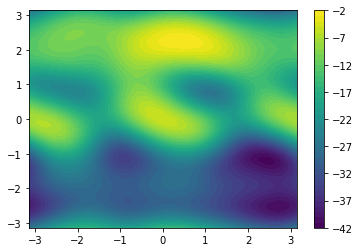

In [26]:
Z = np.load('fes.npy')

X, Y = np.linspace(-np.pi, np.pi, len(Z)), np.linspace(-np.pi, np.pi, len(Z))

X, Y = np.meshgrid(X,Y)

plt.contourf(X, Y, Z, 40)
plt.colorbar()